In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, confusion_matrix

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

## New York City energy production

The **goal** is to build a Random Forest pipeline and XGB classifier pipeline that predicts the energy produced on a given day.

The model will be trained on 2018 data, and test it on the 2019 data.

**Column descriptions:**

| column | description |
| :-- | --: |
| AWND | Average wind speed |
| PGTM | Peak gust time |
| PRCP | Precipitation |
| SNOW | Snowfall |
| SNWD | Snow depth |
| TAVG | Average Temperature |
| TMAX | Maximum temperature |
| TMIN | Minimum temperature |
| WDF2 | Direction of fastest 2-minute wind |
| WDF5 | Direction of fastest 5-second wind |
| WSF2 | Fastest 2-minute wind speed |
| WSF5 | Fastest 5-second wind speed |
| WT01 | Fog, ice fog, or freezing fog (may include heavy fog) |
| WT02 | Heavy fog or heaving freezing fog (not always distinguished from fog) |
| WT03 | Thunder |
| WT04 | Ice pellets, sleet, snow pellets, or small hail |
| WT05 | Hail (may include small hail) |
| WT06 | Glaze or rime |
| WT08 | Smoke or haze |
| WT09 | Blowing or drifting snow | 
| LOAD (**target vector**) | average electricity produced (in Watts) in the CAPITAL zone (see the picture below) |

### Data Exploration

In [2]:
#weather data
path = '/Users/liamhettinger/Documents/Portfolio_work/Data/weather_NYC.csv' 
data = pd.read_csv(path,index_col='DATE',parse_dates=True)

#Energy Data
load_18 = pd.read_csv('/Users/liamhettinger/Documents/Portfolio_work/Data/load_NYC_2018.csv', usecols = ['RTD End Time Stamp','RTD Actual Load'], index_col='RTD End Time Stamp', parse_dates=True)
load_19 = pd.read_csv('/Users/liamhettinger/Documents/Portfolio_work/Data/load_NYC_2019.csv', usecols = ['RTD End Time Stamp','RTD Actual Load'], index_col='RTD End Time Stamp', parse_dates=True)

#Merging Dataframes
data['LOAD'] = pd.concat([load_18,load_19]).resample('d').mean() # average energy production
data.head()

,STATION,NAME,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,...,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,LOAD
DATE,,,,,,,,,,,,,,,,,,,,,
2018-01-01,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",17.67,NaN,0.00,0.0,0.0,12,18,7,...,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1719.182034
2018-01-02,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",15.66,NaN,0.00,0.0,0.0,18,26,13,...,29.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1764.714815
2018-01-03,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",8.28,NaN,0.00,0.0,0.0,21,28,12,...,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1699.275172
2018-01-04,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",28.19,NaN,0.49,8.0,1.2,25,29,19,...,55.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1722.843750
2018-01-05,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",25.05,NaN,0.00,0.0,7.9,15,19,9,...,46.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1773.566997


Text(0.5, 0, 'date')

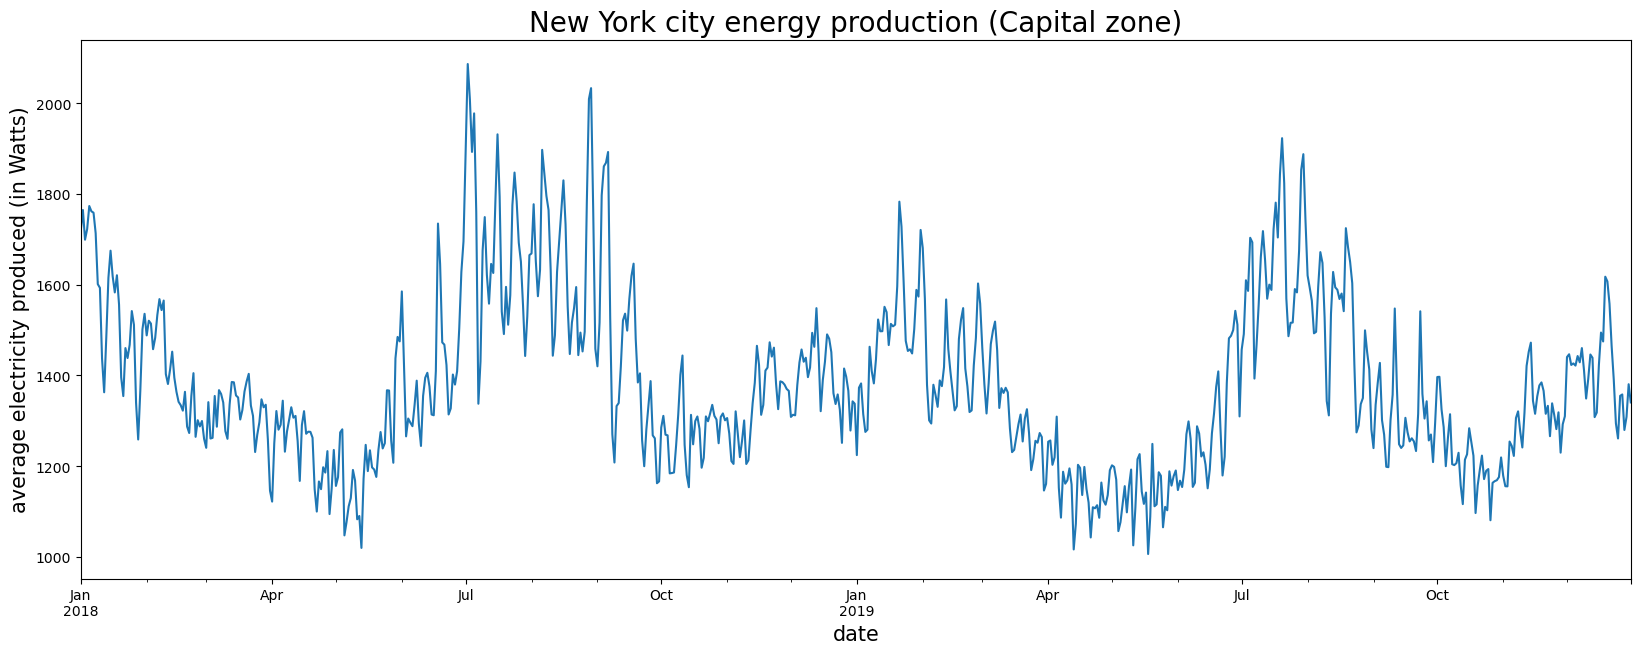

In [3]:
# Showing seasonality
fig, ax = plt.subplots(figsize=(20,7))
data.LOAD.plot(ax=ax)
ax.set_title('New York city energy production (Capital zone)',fontsize=20)
ax.set_ylabel('average electricity produced (in Watts)', fontsize=15)
ax.set_xlabel('date', fontsize=15)

Nyc uses less electricity in the summer than the winter

In [4]:
#Creating date features
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month
data['year'] = data.index.year

In [5]:
#Creating holiday feature
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2018-01-01','2019-12-31')
data['holiday'] = (pd.Series(1, index=holidays,name='holiday'))
data['holiday'].fillna(0, inplace=True)
data['holiday'] = data['holiday'].astype(str)
data['holiday']

DATE
2018-01-01    1.0
2018-01-02    0.0
2018-01-03    0.0
2018-01-04    0.0
2018-01-05    0.0
             ... 
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
Name: holiday, Length: 730, dtype: object

In [6]:
#Handling NA Values

#Removing rows without wind data
data = data[data['WSF5'].notna()]
data = data[data['WDF5'].notna()]

#Viewing NA values
data.isna().sum()

STATION          0
NAME             0
AWND             0
PGTM           724
PRCP             0
SNOW             0
SNWD             0
TAVG             0
TMAX             0
TMIN             0
WDF2             0
WDF5             0
WSF2             0
WSF5             0
WT01           406
WT02           661
WT03           662
WT04           710
WT05           723
WT06           716
WT08           707
WT09           721
LOAD             0
day_of_week      0
month            0
year             0
holiday          0
dtype: int64

### Feature Selection

In [7]:
#Defining features 
cat = ['day_of_week', 'holiday', 'month']
num = ['AWND', 'PRCP','SNOW', 'SNWD']#, 'TAVG', 'TMAX', 'TMIN', 'WSF2', 'WSF5','WDF2','WDF5']

data = data[cat + num + ['LOAD']]

In [8]:
#defining X and Y
y = data['LOAD']
X = data.drop('LOAD',axis=1)

In [9]:
# training - test split
#Training on 2018 data and testing on 2019 data
X_train = X[X.index.year==2018]
y_train = y[y.index.year==2018]
X_test = X[X.index.year==2019]
y_test = y[y.index.year==2019]

### Pipeline
- **OneHotEncoder** transforms each categorical feature with n_categories possible values into n_categories binary features, with one of them 1, and all others 0.
- **MinMaxScaler** transforms an numerical range into a standard range of values [-1,1]

In [10]:
# pipeline
processor = ColumnTransformer(transformers = [
    ('encoder', OneHotEncoder(handle_unknown='ignore'), cat), #Categorical features
    ('scaler', MinMaxScaler(), num) #can help with training speed
])

pipe = Pipeline(steps=[
    ('preprocessor',processor),
    ('reg', RandomForestRegressor())
])

### Random Forest Regressor Parameters

- **min_samples_leaf** minimum samples required on output leaf node
- **min_samples_split** minimum samples required in node to split
- **n_estimators** number of trees
- **max_depth** max depth of the trees. prevents overfitting

In [11]:
parameters = {"reg__min_samples_leaf" : [1,2], 
              "reg__min_samples_split" : [2,4,8], 
              "reg__n_estimators" : [200, 500], 
              "reg__max_depth" : [4,5,6,7,8]} 

### Fitting Model

In [12]:
grid = GridSearchCV(pipe, parameters, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=True, error_score='raise')

In [13]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['day_of_week',
                                                                          'holiday',
                                                                          'month']),
                                                                        ('scaler',
                                                                         MinMaxScaler(),
                                                                         ['AWND',
                                                                          'PRCP',
                                                                          'SNOW',
                                                                          'SNWD'])])),
                                       ('reg', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'reg__max_depth': [4, 5, 6, 7, 8],
                         'reg__min_samples_leaf': [1, 2],
                         'reg__min_samples_split': [2, 4, 8],
                         'reg__n_estimators': [200, 500]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [10]:
#Grids best accuracy score
grid.best_score_

0.8334157056562328

In [11]:
#parameters used to acheive best accuracy score
grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 100}

In [14]:
y_test_pred_random_forest = grid.predict(X_test)

## XGBoost Classification

In [15]:
#pipeline and processor
processor = ColumnTransformer(transformers = [
    ('encoder', OneHotEncoder(handle_unknown='ignore'), cat), #Categorical features
    ('scaler', MinMaxScaler(), num) #can help with training speed
])

pipe = Pipeline(steps=[
    ('preprocessor',processor),
    ('xgb', xgb.XGBRegressor())
])


- **colsample_bytree** proportion of the sample used to train the tree. Similar to a random forest. 
- **Gamma** Required loss reduction to make another node. The larger gamma is, the more conservative the algorithm will be. Range: [0,∞]
- **learning_rate** Boosting assigns feature weights. The learning rate shrinks those weights to prevent overfitting. Step size shrinkage. Prevents overfitting. range: [0,1]
- **max_depth** Maximum depth of a tree. Larger number of trees can cause overfitting. 0 means no limit. range: [0,∞]

In [16]:
parameters = {
    'xgb__colsample_bytree' : [0.3, 0.6, 0.7],
    'xgb__gamma' : [0.1, 0.2],
    "xgb__learning_rate": [.05, .1],
    "xgb__max_depth": [0, 5, 20, 50]
}

In [17]:
# Grid Search model
grid = GridSearchCV(pipe,parameters,cv=5,scoring='neg_root_mean_squared_error',n_jobs=-1,verbose=True)

In [18]:
# Fitting model
grid.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['day_of_week',
                                                                          'holiday',
                                                                          'month']),
                                                                        ('scaler',
                                                                         MinMaxScaler(),
                                                                         ['AWND',
                                                                          'PRCP',
                                                                          'SNOW',
                                                                          'SNWD'])])),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsa...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.3, 0.6, 0.7],
                         'xgb__gamma': [0.1, 0.2],
                         'xgb__learning_rate': [0.05, 0.1],
                         'xgb__max_depth': [0, 5, 20, 50]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [10]:
#Grids best accuracy score
grid.best_score_

0.8334157056562328

In [11]:
#parameters used to acheive best accuracy score
grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 100}

In [19]:
#Predicting Y_test
y_test_pred_XGB = grid.predict(X_test)

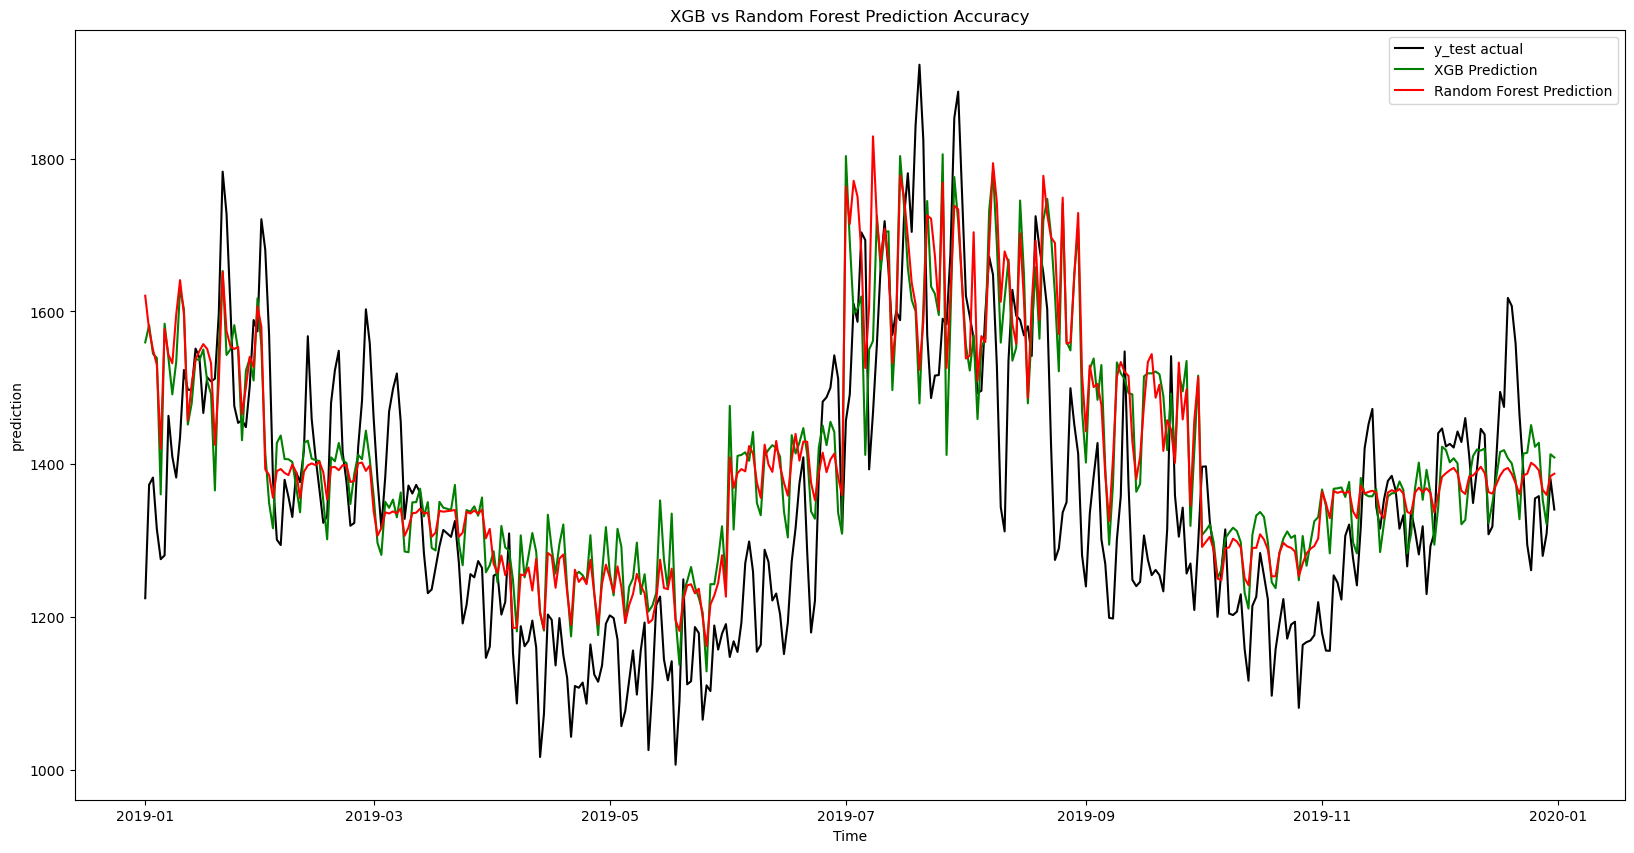

In [22]:
#Comparing Y_test actual predictions with the XGB and Random Forest Predictions
plt.figure(figsize=(20, 10))
plt.plot(y_test.index, y_test, label = 'y_test actual', color="black")
plt.plot(y_test.index,y_test_pred_XGB, label = 'XGB Prediction', color="green")
plt.plot(y_test.index,y_test_pred_random_forest, label = 'Random Forest Prediction', color="red")
plt.xlabel('Time')
plt.ylabel('prediction')
plt.title('XGB vs Random Forest Prediction Accuracy')
plt.legend()
plt.show()

In [23]:
#XGB MSE
mean_squared_error(y_test, y_test_pred_XGB)

17395.51167132706

In [24]:
#Random Forest MSE
mean_squared_error(y_test, y_test_pred_random_forest)

17510.596946679576